# Introduction

Background removal example using BiRefNet.

**Before executing:**

* In the root `BiRefNet` directory, create an `images_todo` direcotry. Inside this directory, create an `images` directory that should contain the image you want to remove the background from.

* Again in the `images_todo` directory, create a `backgrounds` directory that should contain the backgrounds that you want your images' background to be replaced with.

* Next, create a `weights` directory in the root `BiRefNet` directory, and keep the weights after downloading from this link => https://github.com/ZhengPeng7/BiRefNet/releases/download/v1/BiRefNet-general-epoch_244.pth

```
BiRefNet
├── evaluation
│   └── metrics.py
├── images_todo
│   ├── backgrounds
│   └── images
├── models
│   ├── backbones
│   ├── modules
│   ├── refinement
│   └── birefnet.py
├── tutorials
│   ├── birefnet_background_removal.ipynb
│   ├── birefnet_background_replacement.ipynb
│   ├── BiRefNet_inference.ipynb
│   ├── BiRefNet_inference_video.ipynb
│   └── BiRefNet_pth2onnx.ipynb
├── weights
│   ├── BiRefNet-general-bb_swin_v1_tiny-epoch_232.pth
│   └── BiRefNet-general-epoch_244.pth
├── config.py
├── dataset.py
├── eval_existingOnes.py
├── gen_best_ep.py
├── image_proc.py
├── inference.py
├── LICENSE
├── loss.py
├── make_a_copy.sh
├── README.md
├── requirements.txt
├── rm_cache.sh
├── sub.sh
├── test.sh
├── train.py
├── train.sh
├── train_test.sh
└── utils.py
```

In [1]:
# !wget https://github.com/ZhengPeng7/BiRefNet/releases/download/v1/BiRefNet-general-epoch_244.pth -O ../weights/BiRefNet-general-epoch_244.pth

In [2]:
import sys

# BiRefNet modules are present one directory back. 
sys.path.append('../')

import torch
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from torchvision import transforms
from IPython.display import display
from models.birefnet import BiRefNet
from utils import check_state_dict
from glob import glob
from image_proc import refine_foreground

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = 'cpu'

In [4]:
def load_model():
    birefnet = BiRefNet(bb_pretrained=False)
    state_dict = torch.load('../weights/BiRefNet-general-epoch_244.pth', map_location=device)
    state_dict = check_state_dict(state_dict)
    birefnet.load_state_dict(state_dict)
    
    # Load Model
    torch.set_float32_matmul_precision(['high', 'highest'][0])
    
    birefnet.to(device)
    birefnet.eval()
    print('BiRefNet is ready to use.')
    birefnet.half()

    return birefnet

In [5]:
# Choose from: 'BiRefNet', 'BiRefNet_HR', 'BiRefNet_HR-matting'
model_name = 'BiRefNet_HR'
model = load_model()

BiRefNet is ready to use.


In [6]:
transform_image = transforms.Compose([
    transforms.Resize((1024, 1024) if '_HR' not in model_name else (2048, 2048)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Remove Background

In [7]:
def run_inference(image_path):
    image = Image.open(image_path)
    input_images = transform_image(image).unsqueeze(0).to(device)
    input_images = input_images.half()

    # Prediction
    with torch.no_grad():
        preds = model(input_images)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()

    # Save Results
    file_ext = os.path.splitext(image_path)[-1]
    pred_pil = transforms.ToPILImage()(pred)
    pred_pil = pred_pil.resize(image.size)
    pred_pil.save(image_path.replace(src_dir, dst_dir).replace(file_ext, '-mask.png'))
    image_masked = refine_foreground(image, pred_pil)
    image_masked.putalpha(pred_pil)
    image_masked.save(image_path.replace(src_dir, dst_dir).replace(file_ext, '-subject.png'))

    # Visualize the last sample:
    # Scale proportionally with max length to 1024 for faster showing
    scale_ratio = 1024 / max(image.size)
    scaled_size = (int(image.size[0] * scale_ratio), int(image.size[1] * scale_ratio))
    
    plt.figure(figsize=(15, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(image_masked)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(pred_pil, cmap='gray')
    plt.axis('off')

    plt.show()

Processing ../images_todo/images/image_1.jpg ...


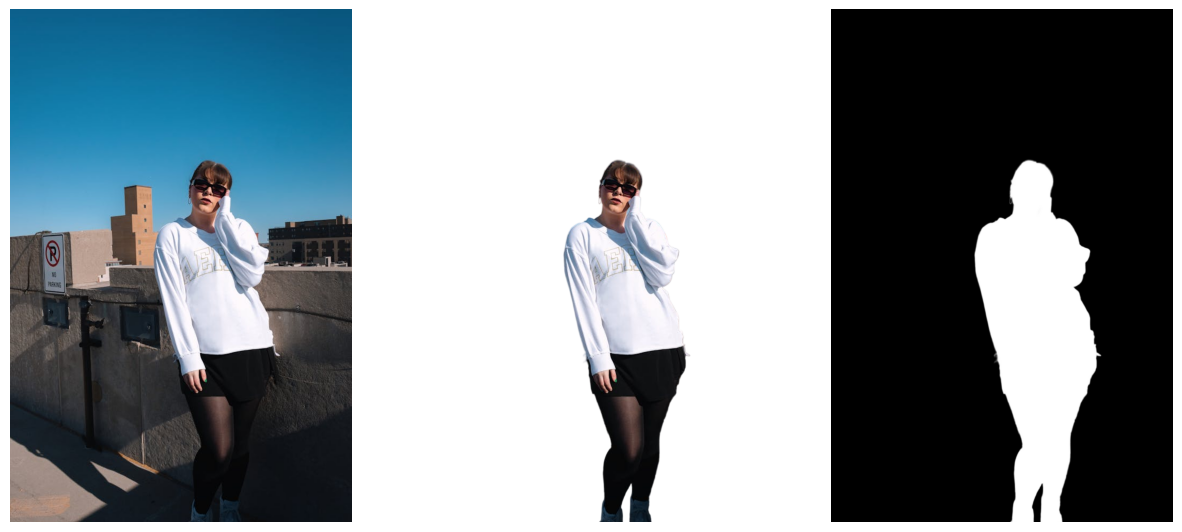

Processing ../images_todo/images/image_2.jpg ...


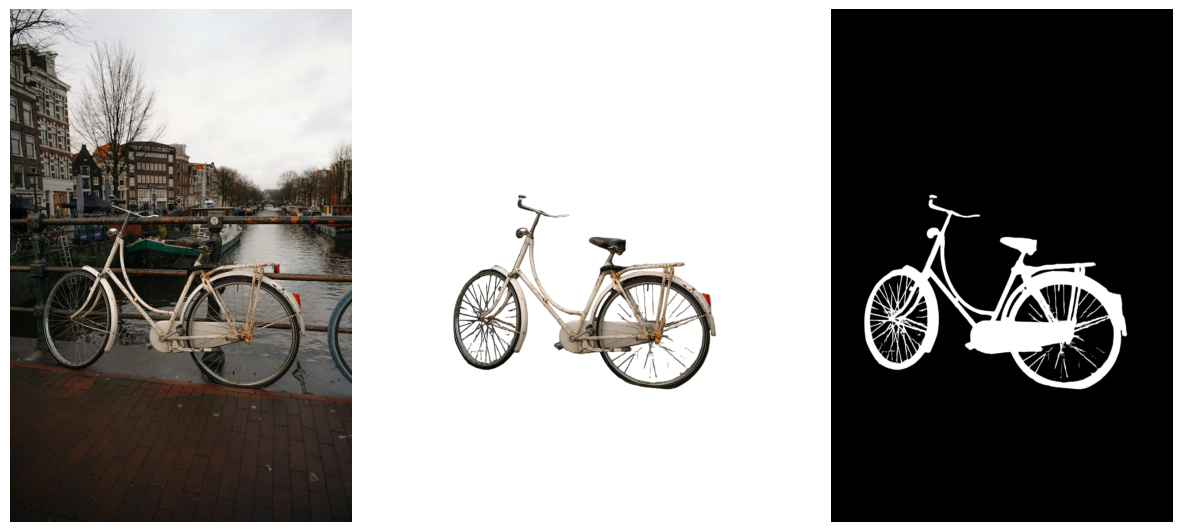

Processing ../images_todo/images/image_3.jpg ...


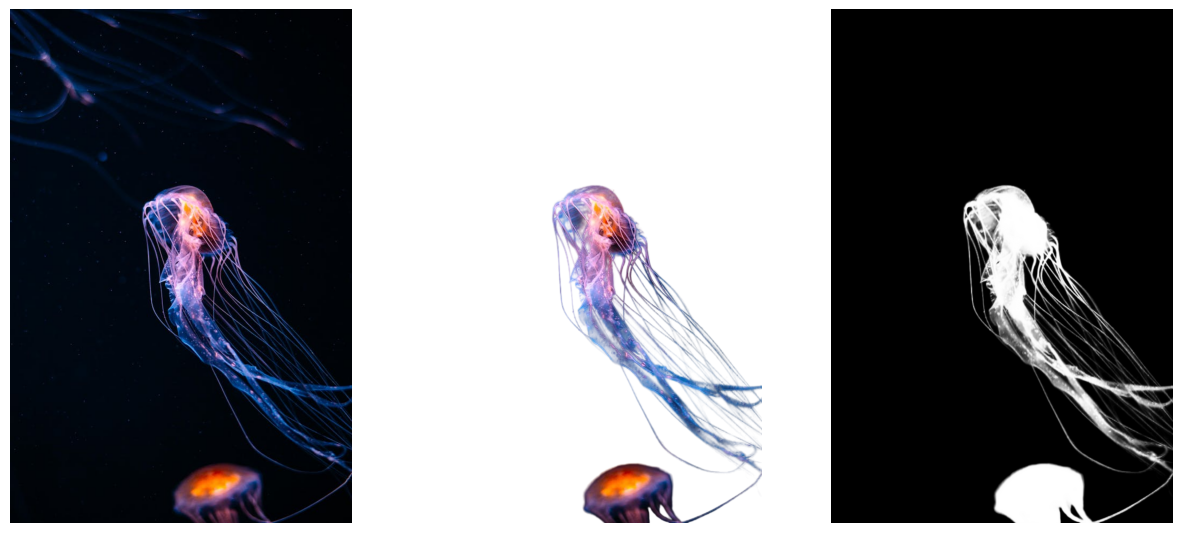

In [8]:
src_dir = '../images_todo/images'
image_paths = glob(os.path.join(src_dir, '*'))
dst_dir = '../predictions/'
os.makedirs(dst_dir, exist_ok=True)

for image_path in image_paths:
    print('Processing {} ...'.format(image_path))
    run_inference(image_path)

## Change Background

In [9]:
def apply_new_background(subject_binary, foreground, background):
    """
    :param subject_binary: mask containing the foreground binary pixels
    :param foreground: mask containg the extracted foreground image
    :param save_name: name of the input image file
    """
    # normalization of mask3d mask, keeping values between 0 and 1
    subject_binary = subject_binary / 255.0
    # get the scaled product by multiplying
    foreground = cv2.multiply(subject_binary.astype(np.float32), foreground.astype(np.float32))
    # resize it according to the foreground image
    background = cv2.resize(background, (foreground.shape[1], foreground.shape[0]))
    background = background.astype(np.float32)
    # get the scaled product by multiplying
    background = cv2.multiply(1.0 - subject_binary.astype(np.float32), background.astype(np.float32))
    # add the foreground and new background image
    new_image = cv2.add(foreground.astype(np.float32), background.astype(np.float32))
    return new_image/255.

(962, 640, 3)


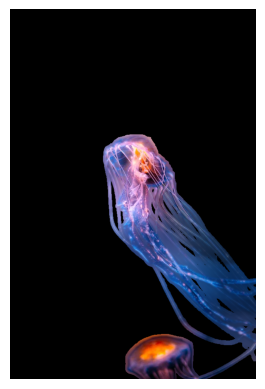

In [10]:
subject = cv2.imread('../predictions/image_3-subject.png')
subject = cv2.cvtColor(subject, cv2.COLOR_BGR2RGB)
print(subject.shape)
plt.imshow(subject)
plt.axis('off')
plt.show()

In [11]:
subject_binary = cv2.imread('../predictions/image_3-mask.png')

(853, 1280, 3)


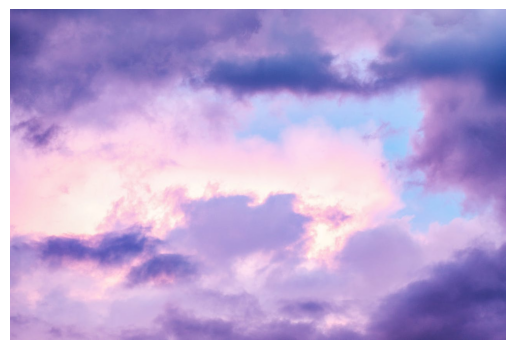

In [12]:
bg = cv2.imread('../images_todo/backgrounds/bg_2.jpg')
bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
print(bg.shape)
plt.imshow(bg)
plt.axis('off')
plt.show()

In [13]:
result = apply_new_background(subject_binary, subject, bg)

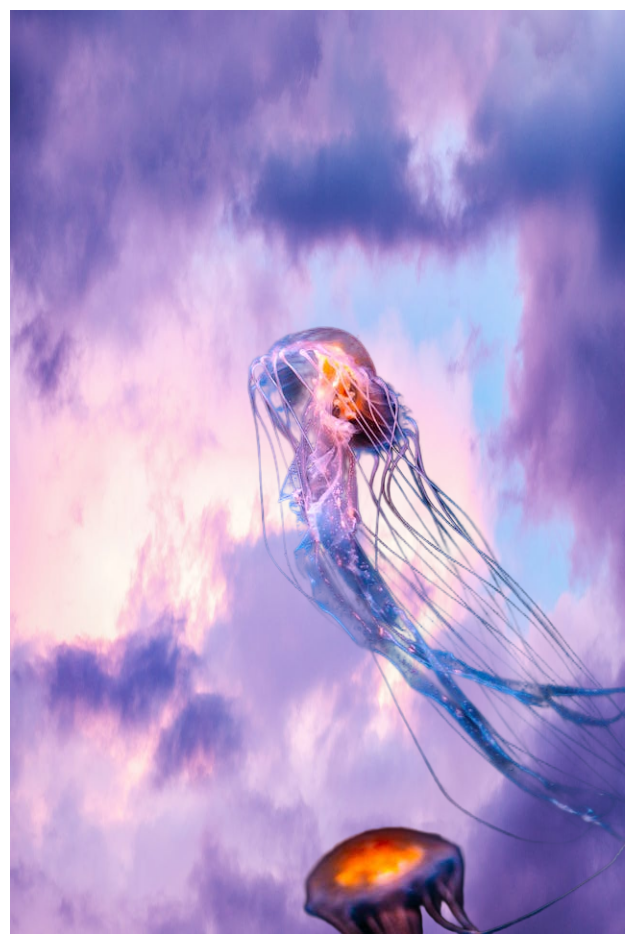

In [14]:
plt.figure(figsize=(15, 12))
plt.imshow(result)
plt.axis('off')
plt.show()